<a href="https://colab.research.google.com/github/yashveersinghsohi/Hands_On_ML_Book_Practice/blob/master/Chapter_8/Chapter8_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.datasets import fetch_openml, make_swiss_roll
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.manifold import LocallyLinearEmbedding, TSNE

# PCA

**Data**

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [7]:
mnist.data.shape

(70000, 784)

In [6]:
mnist.data[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Model**

In [8]:
pca = PCA(n_components=mnist.data.shape[1], random_state=42)
mnist_pc = pca.fit_transform(mnist.data)

**Choosing the Right Number of Dimensions**

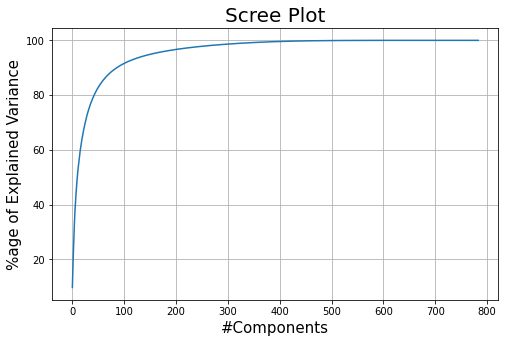

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(pca.explained_variance_ratio_.cumsum()*100)

ax.set_title("Scree Plot", size=20)
ax.set_xlabel("#Components", size=15)
ax.set_ylabel("%age of Explained Variance", size=15)

ax.grid()

plt.show()

**Number of components with 95% variance explainability**

In [20]:
np.argmax(pca.explained_variance_ratio_.cumsum()>=0.95) + 1

154

In [26]:
pca = PCA(n_components=154, random_state=42)
mnist_pc = pca.fit_transform(mnist.data)

**Directly specifying 95% variance explainability in PCA**

In [21]:
pca_95 = PCA(n_components=0.95, random_state=42)
mnist_pc_95 = pca_95.fit_transform(mnist.data)

# Randomized PCA

- Use `svd_solver="randomized"` for Randomized PCA (faster)
- Use `svd_solver="full"` for PCA (slower)

# Incremental PCA

In [34]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(mnist.data, n_batches):
  print(".", end="")
  inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(mnist.data)

....................................................................................................

In [35]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

# Kernel PCA

In [44]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [45]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

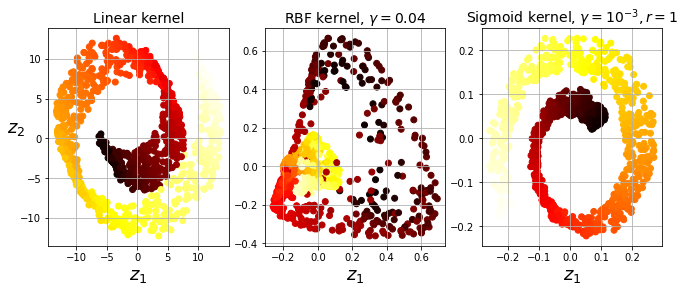

In [47]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

# save_fig("kernel_pca_plot")
plt.show()

**Using Grid Search with Kernel PCA**

In [49]:
clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [50]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

# Locally Linear Embedding (LLE)

In [52]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [54]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [55]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

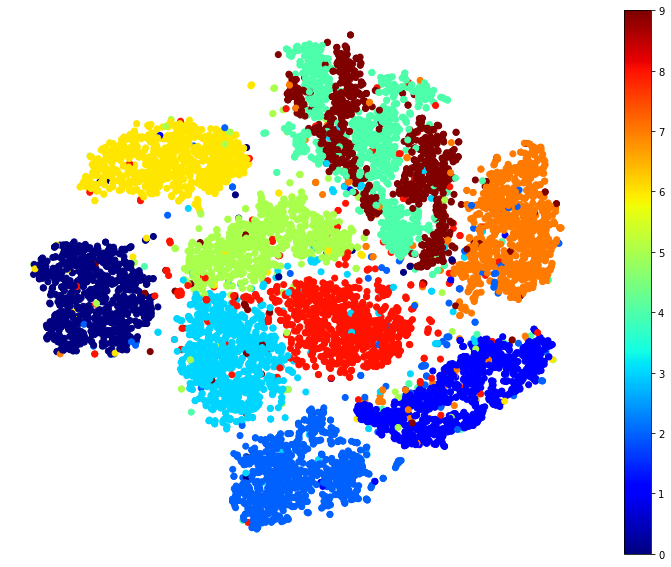

In [56]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()